In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
import scipy.ndimage as nd
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
from sklearn.metrics import accuracy_score
from skimage.feature import local_binary_pattern
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import IncrementalPCA

# Reading the required Data

In [ ]:
#download data
! pip install kaggle # Install the Kaggle library
! mkdir ~/.kaggle # Make a directory named “.kaggle”
! cp /content/kaggle.json ~/.kaggle/ # Copy the “kaggle.json” into this new directory
#Add json file
#! chmod 600 ~/.kaggle/kaggle.json # Allocate the required permission for this file.
!kaggle competitions download "fall2021-inf8245e-machine-learning" # Downloading Competitions dataset
!unzip "/content/x_train.pkl.zip"
!unzip "/content/x_test.pkl.zip"
!unzip "/content/y_train.pkl.zip"

In [ ]:
with open('/content/x_train.pkl, 'rb') as file:
    x = pickle.load(file)
with open('/content/x_test.pkl, 'rb') as file:
    xt = pickle.load(file)
with open('/content/y_train.pkl, 'rb') as file:
    y = pickle.load(file)

In [ ]:
#Install appropriate open cv libraries
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(np.unique(y))
yp = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(x, yp, test_size=0.05, random_state=42)

In [ ]:
#Use this cell to plot the effect of the computer vision features as well as the potential channels
#You can change the variable animal to observe the effect of such features on the different classes
#The last two axis of the plots represent another feature that we thought about using for texture detection called Local Binary Pattern

radius = 3
n_points = 8*radius
METHOD = 'uniform'
animal = 'spider'
fig, ax = plt.subplots(6,7, figsize=(35,15))
fig.tight_layout(pad=3.0)
fig.subplots_adjust(wspace=0.001)
idx = np.random.randint(0, x[y==animal].shape[0], size=7)
t=0

for i in idx:
  temp = np.zeros_like(x[0])
  contrast = x[y==animal][i].std()
  sift = cv2.xfeatures2d.SIFT_create(nfeatures=150, nOctaveLayers=20, sigma=0.8, contrastThreshold=0.001*contrast)
  keypoints_1, descriptors_1 = sift.detectAndCompute(x[y==animal][i],None)
  imgtemp = cv2.drawKeypoints(x[y==animal][i],keypoints_1,x[y==animal][i])
  kp = np.array([i.pt for i in keypoints_1]).astype(int)
  for j in kp:
    temp[j[1],j[0]] = 255
  closing = nd.binary_closing(temp, iterations=15).astype(int)
  sl = np.where(closing == 1)[0].min()
  el = np.where(closing == 1)[0].max()
  sc = np.where(closing == 1)[1].min()
  ec = np.where(closing == 1)[1].max()
  cropped = cv2.resize(x[y==animal][i,sl:el,sc:ec],dsize=(96,96))
  lbp = local_binary_pattern(cropped, n_points, radius, METHOD)
  



  
  
  ax[0][t].imshow(x[y==animal][i])
  ax[0][t].set_title("original image = " + animal + '#'+str(i))
  ax[1][t].imshow(imgtemp)
  ax[1][t].set_title("SIFT_img")
  ax[2][t].imshow(closing)
  ax[2][t].set_title("SIFT + morphology = masked")
  ax[3][t].imshow(cropped)
  ax[3][t].set_title("Cropped")
  
  ax[4][t].imshow(lbp)
  ax[4][t].set_title("Local binary pattern = texture")
  n_bins = int(lbp.max())
  ax[5][t].hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')
  t = t+1
    

In [ ]:
x_mask = np.zeros_like(X_train)
x_masked = np.zeros_like(X_train)
for i in tqdm(range(int(len(X_train)))):
  contrast = X_train[i].std()
  sift = cv2.xfeatures2d.SIFT_create(nfeatures=150, nOctaveLayers=20, sigma=0.8, contrastThreshold=0.001*contrast)
  keypoints_1, descriptors_1 = sift.detectAndCompute(X_train[i],None)
  kp = np.array([i.pt for i in keypoints_1]).astype(int)
  for j in kp:
    x_mask[i, j[1],j[0]] = 255
  x_mask[i] = nd.binary_closing(x_mask[i], iterations=20).astype(int)
  x_masked[i] = (x_mask[i])*X_train[i]

  0%|          | 0/11292 [00:00<?, ?it/s]

In [ ]:
x_cropped = []
for i in tqdm(range(len(X_train))):
  sl = np.where(x_mask[i] == 1)[0].min()
  el = np.where(x_mask[i] == 1)[0].max()
  sc = np.where(x_mask[i] == 1)[1].min()
  ec = np.where(x_mask[i] == 1)[1].max()

  x_cropped.append(cv2.resize(X_train[i,sl:el,sc:ec],dsize=(96,96)))

  0%|          | 0/11292 [00:00<?, ?it/s]

In [ ]:
xt_mask = np.zeros_like(X_test)
xt_masked = np.zeros_like(X_test)
for i in tqdm(range(int(len(X_test)))):
  contrast = X_test[i].std()
  sift = cv2.xfeatures2d.SIFT_create(nfeatures=150, nOctaveLayers=20, sigma=0.8, contrastThreshold=0.001*contrast)
  keypoints_1, descriptors_1 = sift.detectAndCompute(X_test[i],None)
  kp = np.array([i.pt for i in keypoints_1]).astype(int)
  for j in kp:
    xt_mask[i, j[1],j[0]] = 255
  xt_mask[i] = nd.binary_closing(xt_mask[i], iterations=20).astype(int)
  xt_masked[i] = (xt_mask[i])*X_test[i]

  0%|          | 0/595 [00:00<?, ?it/s]

In [ ]:
xt_cropped = []
for i in tqdm(range(len(X_test))):
  sl = np.where(x_mask[i] == 1)[0].min()
  el = np.where(x_mask[i] == 1)[0].max()
  sc = np.where(x_mask[i] == 1)[1].min()
  ec = np.where(x_mask[i] == 1)[1].max()

  xt_cropped.append(cv2.resize(X_test[i,sl:el,sc:ec],dsize=(96,96)))

  0%|          | 0/595 [00:00<?, ?it/s]

In [ ]:
Xr_train = []
xr_mask = []
xr_cropped = []
for i in tqdm(range(len(X_train))):
  Xr_train.append(cv2.resize(X_train[i], dsize=(299,299)))
  xr_mask.append(cv2.resize(x_mask[i], dsize=(299,299)))
  xr_cropped.append(cv2.resize(x_cropped[i], dsize=(299,299)))


  0%|          | 0/11292 [00:00<?, ?it/s]

In [ ]:
Xtr = np.stack([np.array(Xr_train), np.array(xr_mask), np.array(xr_cropped)], axis=-1)

In [ ]:
model = tf.keras.applications.Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=11,
    classifier_activation="softmax",
)

In [ ]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 149, 149, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
Xtrain, Xval, ytrain, yval = train_test_split(Xtr, y_train, test_size=0.05, random_state=42)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

EPOCHS = 300
checkpoint_filepath = './drive/MyDrive/Kagge/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval), epochs=EPOCHS, callbacks=[model_checkpoint_callback])

Epoch 1/300
336/336 [==============================] - 254s 713ms/step - loss: 1.9175 - accuracy: 0.3524 - val_loss: 2.3594 - val_accuracy: 0.1805
Epoch 2/300
336/336 [==============================] - 238s 707ms/step - loss: 1.5270 - accuracy: 0.4772 - val_loss: 4.9052 - val_accuracy: 0.2584
Epoch 3/300
336/336 [==============================] - 240s 715ms/step - loss: 1.2898 - accuracy: 0.5670 - val_loss: 3.6311 - val_accuracy: 0.3363
Epoch 4/300
336/336 [==============================] - 238s 709ms/step - loss: 1.1041 - accuracy: 0.6231 - val_loss: 1.6054 - val_accuracy: 0.5628
Epoch 5/300
336/336 [==============================] - 236s 703ms/step - loss: 0.9393 - accuracy: 0.6861 - val_loss: 2.3955 - val_accuracy: 0.4301
Epoch 6/300
336/336 [==============================] - 236s 703ms/step - loss: 0.7941 - accuracy: 0.7343 - val_loss: 2.3957 - val_accuracy: 0.5133
Epoch 7/300
336/336 [==============================] - 238s 707ms/step - loss: 0.6785 - accuracy: 0.7691 - val_loss: 1

KeyboardInterrupt: ignored

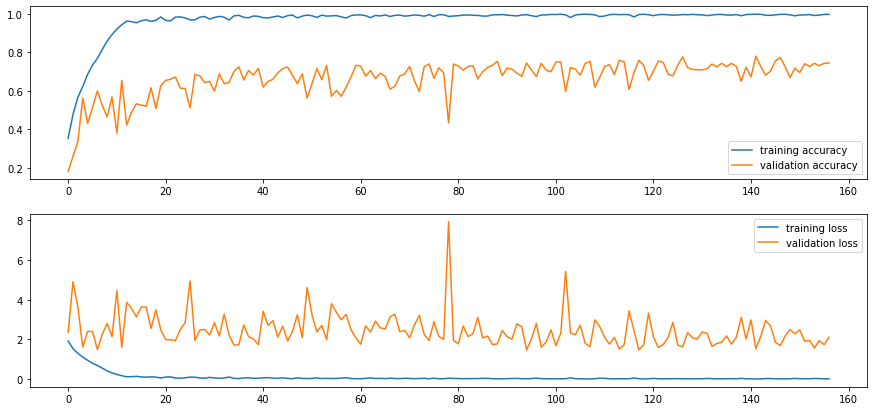

In [ ]:
fig, ax = plt.subplots(2,1,figsize = (15,7))
ax[0].plot(np.arange(0, len(model.history.history['accuracy']),1), model.history.history['accuracy'], label = 'training accuracy')
ax[0].plot(np.arange(0, len(model.history.history['val_accuracy']),1), model.history.history['val_accuracy'], label = 'validation accuracy')
ax[1].plot(np.arange(0, len(model.history.history['loss']),1), model.history.history['loss'], label = 'training loss')
ax[1].plot(np.arange(0, len(model.history.history['val_loss']),1), model.history.history['val_loss'], label = 'validation loss')
ax[0].legend()
ax[1].legend()

In [ ]:
fig.savefig("learning_curves")

In [ ]:
#Extract best model

model = tf.keras.applications.Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=11,
    classifier_activation="softmax",
)

checkpoint_filepath = './drive/MyDrive/Kagge/tmp/checkpoint'
model.load_weights(checkpoint_filepath)


In [ ]:
#Validation accuraccy
y_hat = np.argmax(model.predict(Xval), axis=1)
accuracy_score(y_hat, yval)

In [ ]:
#Creating the submission 

x_mask = np.zeros_like(xt)
x_masked = np.zeros_like(xt)
for i in tqdm(range(int(len(xt)))):
  contrast = xt[i].std()
  sift = cv2.xfeatures2d.SIFT_create(nfeatures=150, nOctaveLayers=20, sigma=0.8, contrastThreshold=0.001*contrast)
  keypoints_1, descriptors_1 = sift.detectAndCompute(xt[i],None)
  kp = np.array([i.pt for i in keypoints_1]).astype(int)
  for j in kp:
    x_mask[i, j[1],j[0]] = 255
  x_mask[i] = nd.binary_closing(x_mask[i], iterations=20).astype(int)
  x_masked[i] = (x_mask[i])*xt[i]

  0%|          | 0/17831 [00:00<?, ?it/s]

In [ ]:
x_cropped = []
for i in tqdm(range(len(xt))):
  if (np.count_nonzero(xt[i]) == 0):
    print(i)
    x_cropped.append(np.zeros((96,96)))
  else:
    sl = np.where(x_mask[i] == 1)[0].min()
    el = np.where(x_mask[i] == 1)[0].max()
    sc = np.where(x_mask[i] == 1)[1].min()
    ec = np.where(x_mask[i] == 1)[1].max()

    x_cropped.append(cv2.resize(xt[i,sl:el,sc:ec],dsize=(96,96)))

  0%|          | 0/17831 [00:00<?, ?it/s]

5613


In [ ]:
X_test = []
xt_mask = []
xt_cropped = []
for i in tqdm(range(len(xt))):
  X_test.append(cv2.resize(xt[i], dsize=(299,299)))
  xt_mask.append(cv2.resize(x_mask[i], dsize=(299,299)))
  xt_cropped.append(cv2.resize(x_cropped[i], dsize=(299,299)))

  0%|          | 0/17831 [00:00<?, ?it/s]

In [ ]:
#We have to add the arrays one by one to not saturate the RAM
Xtest1 = np.stack([np.array(X_test[:5613]), np.array(xt_mask[:5613]), np.array(xt_cropped[:5613])], axis=-1)
#Xtest2 = np.stack([np.array(X_test[]), np.array(xt_mask[5000:10000]), np.array(xt_cropped[5000:10000])], axis=-1)

In [ ]:
Xtest2 = np.stack([np.array(X_test[5614:]), np.array(xt_mask[5614:]), np.array(xt_cropped[5614:])], axis=-1)


In [ ]:
y1 = np.argmax(model.predict(Xtest1), axis=1)

In [ ]:
y2 = np.argmax(model.predict(Xtest2), axis=1)

In [ ]:
y2 = np.insert(y2, 0, 0)

In [ ]:
y_cv = np.concatenate((y1, y2))

In [ ]:
np.save('./y_cv.npy', y_cv)

In [ ]:
df = pd.DataFrame({"id":np.arange(0,17831,1), "class": y_cv})

In [ ]:
y1 = pd.read_csv('./subs/y_cv.csv')
y2 = pd.read_csv('./subs/DENSENET_81.csv')
y3 = pd.read_csv('./subs/RESNET_3_log_softmax_82.csv')
y4 = pd.read_csv('./subs/RESNET_81.csv')
y5 = pd.read_csv('./subs/sub_vgg19.csv')

In [ ]:
yf['p2'] = y2['class']
yf['p3'] = y3['class']
yf['p4'] = y4['class']
yf['p5'] = y5['class']

In [ ]:
yfinal_final = pd.DataFrame({"id":np.arange(0,17831,1), "class":yf.T.mode().iloc[0,:].T.astype(int)})

In [ ]:
yfinal_final.to_csv('./subs/y_yfinal_final.csv', index=False)